## Housing Data Analysis

### Importing Data

In [0]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [0]:
DOWNLOAD_ROOT= "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [0]:
def fetch_housing_data(housing_url= HOUSING_URL, housing_path= HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path= os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path= housing_path)
    housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
def load_housing_data(housing_path= HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

## First Preview of Data

In [149]:
housing_df = load_housing_data()
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Information on Features

In [150]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Basic Summary of Features

In [151]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45ad85ebe0>,
      dtype=object)

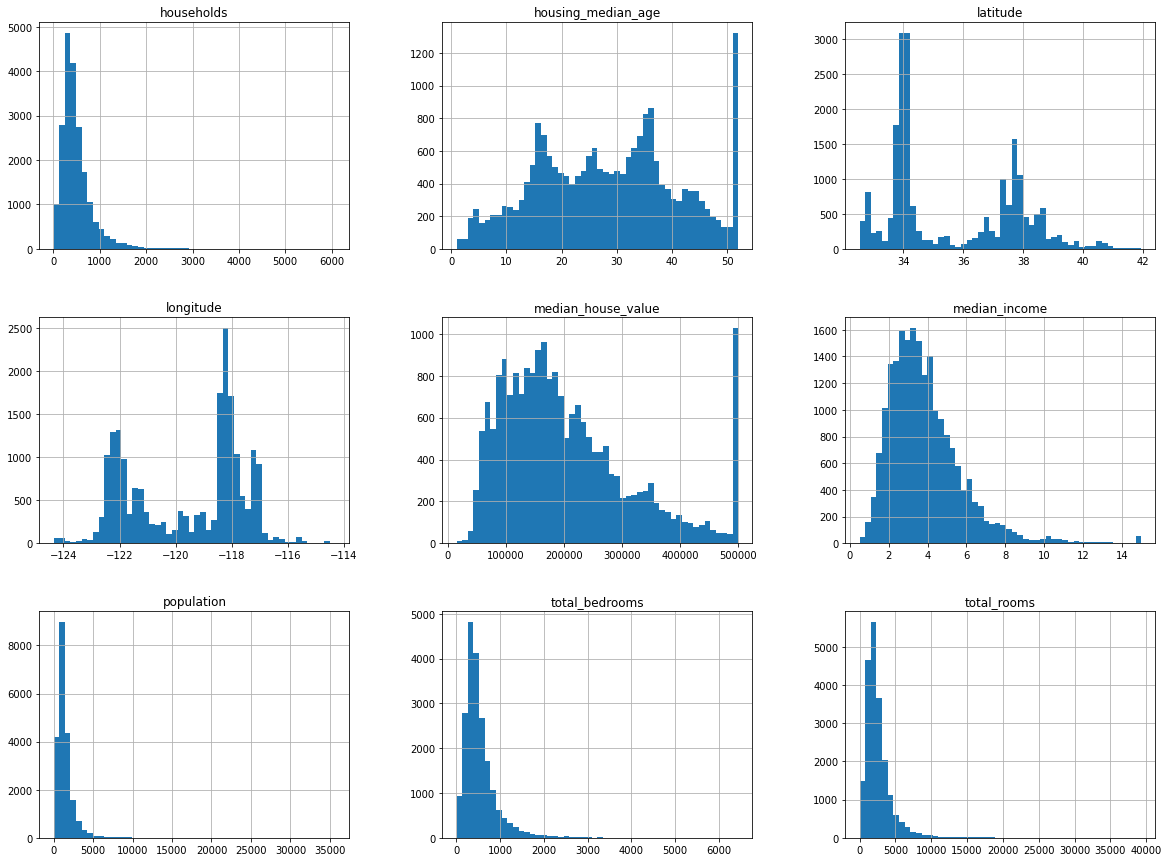

In [152]:
%matplotlib inline 
housing_df.hist(bins= 50, figsize =(20,15))

### Splitting the data

In [0]:
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(test_ratio * len(data))
    train_data = data.iloc[shuffled_indices[test_size:]]
    test_data = data.iloc[shuffled_indices[:test_size]]
    return train_data,test_data

In [154]:
test_ratio = 0.2
train_data,test_data = split_train_test(housing_df,0.2)
print(len(train_data),len(test_data))

16512 4128


In [0]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(housing_df,test_size =0.2,random_state = 42)

### Stratified Splitting of the Data

The data will be stratified on the basis of median income

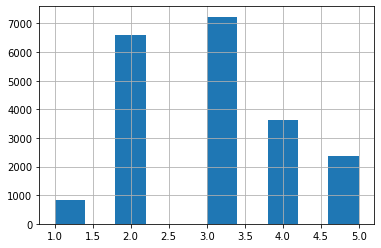

In [156]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],bins = [0,1.5,3,4.5,6,np.inf],labels = [1,2,3,4,5])
housing_df["income_cat"].hist()

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for strat_train_indices,strat_test_indices in sss.split(X = housing_df,y =housing_df["income_cat"]):
    strat_train_data = housing_df.loc[strat_train_indices]
    strat_test_data = housing_df.loc[strat_test_indices]

for set_ in(strat_train_data, strat_test_data):
    set_.drop("income_cat",axis = 1 , inplace =True)


## Visualizing the Data

In [0]:
housing_copy = strat_train_data.copy()  #Create a copy of the dataframe

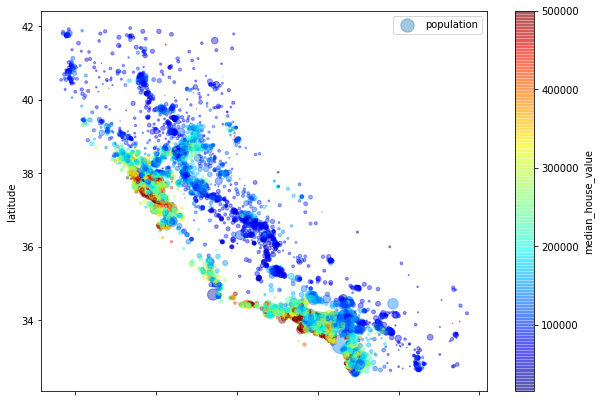

In [159]:
housing_copy.plot(kind= 'scatter', x= "longitude", y= "latitude", alpha = 0.4, s= housing_copy["population"]/100,
                 c= "median_house_value", cmap= plt.get_cmap("jet"), colorbar= True, label="population",
                 figsize= (10,7))
plt.legend()

## Correlation

In [160]:
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Creating more useful variables

In [0]:
housing_copy["rooms_per_household"]= housing_copy["total_rooms"]/housing_copy["households"]
housing_copy["population_per_household"]= housing_copy["population"]/housing_copy["households"]
housing_copy["bedroom_room_ratio"]= housing_copy["total_bedrooms"]/housing_copy["total_rooms"]

### Checking new correlation matrix

In [162]:
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_room_ratio         -0.259984
Name: median_house_value, dtype: float64

## Data Cleaning

## Split the data and the labels

In [0]:
housing_labels = housing_copy["median_house_value"]
housing_data = housing_copy.drop("median_house_value",axis='columns')

## Numerical Cleaning

In [0]:
imputer = SimpleImputer(strategy='median')
housing_data_numerical = housing_data.drop(columns="ocean_proximity")
imputer.fit(housing_data_numerical)
housing_train= pd.DataFrame(imputer.transform(housing_data_numerical),columns= housing_data_numerical.columns)

## Text Cleaning

In [165]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
op = housing_data[["ocean_proximity"]]
ohe.fit_transform(op)
text_columns_names = list(ohe.get_feature_names())
text_columns_names = [i[3:] for i in text_columns_names]
print(text_columns_names)

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


## Custom Transformers
### Transformer to create numerical attributes created above

In [0]:
housing_temp = housing_data

from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesMaker(BaseEstimator,TransformerMixin):
    def __init__(self,add_population_per_household = True):
        self.add_population_per_household = add_population_per_household
    def fit(self,X,y= None):
        return self
    def transform(self,X,y=None):
        X = pd.DataFrame(X)
        X.columns = housing_data.columns.drop("ocean_proximity")
        if self.add_population_per_household:
            X["rooms_per_household"]= X["total_rooms"]/X["households"]
            X["population_per_household"]= X["population"]/X["households"]
            X["bedroom_room_ratio"]= X["total_bedrooms"]/X["total_rooms"]
        else:
            X["bedroom_room_ratio"]= X["total_bedrooms"]/X["total_rooms"]
            X["rooms_per_household"]= X["total_rooms"]/X["households"]
        return X

In [167]:
imputer = SimpleImputer(strategy='median')
housing_data_numerical = housing_data.drop(columns="ocean_proximity")
imputer.fit(housing_data_numerical)
housing_data_numerical= pd.DataFrame(imputer.transform(housing_data_numerical),columns= housing_data_numerical.columns)
cy= CombinedAttributesMaker(add_population_per_household=True).transform(housing_data_numerical)
cy.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedroom_room_ratio
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,4.625369,2.094395,0.223852
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,6.008850,2.707965,0.159057
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,4.225108,2.025974,0.241291
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,5.232295,4.135977,0.200866
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,4.505810,3.047847,0.231341


## Feature Scaling 

In [168]:
from sklearn.preprocessing import StandardScaler
standard_scaler= StandardScaler()
cy = pd.DataFrame(standard_scaler.fit_transform(cy))
cy.columns = housing_data_numerical.columns
cy.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedroom_room_ratio
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928


## Transformation Pipeline

In [0]:
housing_data = housing_temp
from sklearn.pipeline import Pipeline

numerical_processing = Pipeline([
                                ('imputer',SimpleImputer(strategy='median')),
                                ('attribute_maker',CombinedAttributesMaker()),
                                ('standard_scaler',StandardScaler())
])

housing_numerical = housing_data.drop(columns="ocean_proximity")

In [0]:
from sklearn.compose import ColumnTransformer

num_columns = housing_numerical.columns
text_columns = ['ocean_proximity']

housing_pipeline= ColumnTransformer([
                    ('number',numerical_processing,num_columns),
                    ('text',OneHotEncoder(),text_columns)
])

In [0]:
housing_data_cleaned = housing_pipeline.fit_transform(housing_data)
col_names = list(housing_numerical.columns)
col_names = col_names + text_columns_names
housing_data_cleaned = pd.DataFrame(housing_data_cleaned,columns=col_names)

In [172]:
housing_data_cleaned.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedroom_room_ratio,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


# Use different models to gather an idea of the best ones

## Support Vector Machine Regressor

In [180]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = [{'kernel':['linear'],'C':[1,5,10,100,500,1000]},{'kernel':['rbf'],'C':[1,5,10],'gamma':['scale','auto']}]
svm = SVR()
grid_search = GridSearchCV(svm, param_grid, return_train_score = True, scoring = 'neg_mean_squared_error')
grid_search.fit(housing_data_cleaned,housing_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 5, 10, 100, 500, 1000],
                          'kernel': ['linear']},
                         {'C': [1, 5, 10], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [181]:
cvres = grid_search.cv_results_
for mean_score,params in zip(cvres["mean_test_score"],cvres["params"]):
  print(np.sqrt(-mean_score),params)

112571.9845974018 {'C': 1, 'kernel': 'linear'}
95066.89952171071 {'C': 5, 'kernel': 'linear'}
84654.24944894915 {'C': 10, 'kernel': 'linear'}
71603.17710755806 {'C': 100, 'kernel': 'linear'}
70538.39549256714 {'C': 500, 'kernel': 'linear'}
70445.3835347414 {'C': 1000, 'kernel': 'linear'}
118631.71004256308 {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
118634.4106689143 {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
117508.07539783238 {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}
117531.43159173557 {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
116122.31346416594 {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
116146.756839778 {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [176]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64